In [1]:
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.stats as stats
import utils
import xarray as xr

# Clean Traffic Data

In [2]:
year = 2019
# path = f'../nyc_speed_data/*{year}.csv'

# df = utils.load_csv(path)

In [3]:
# df = df.dropna()
# df['DataAsOf'] = pd.to_datetime(df['DataAsOf'])

In [4]:
# df['Speed_norm'] = 0
# for group in df.groupby('Id'):
#     df_tem = group[1]
#     df_tem['Speed_norm'] = stats.zscore(df_tem['Speed'])
#     df['Speed_norm'][df.index.isin(df_tem.index)] = df_tem['Speed_norm']

In [5]:
# df.to_csv(f'traffic_data_clean_{year}.csv')

In [6]:
df = pd.read_csv(f'traffic_data_clean_{year}.csv')
df['DataAsOf'] = pd.to_datetime(df['DataAsOf'])
df = df[['Id','Speed_norm','DataAsOf']]
df.head()

,Id,Speed_norm,DataAsOf
0,1,0.379229,2019-04-01 02:58:11
1,106,-0.883832,2019-04-01 02:58:11
2,110,0.415683,2019-04-01 02:58:04
3,119,-2.081642,2019-04-01 02:58:03
4,124,0.647066,2019-04-01 02:58:03


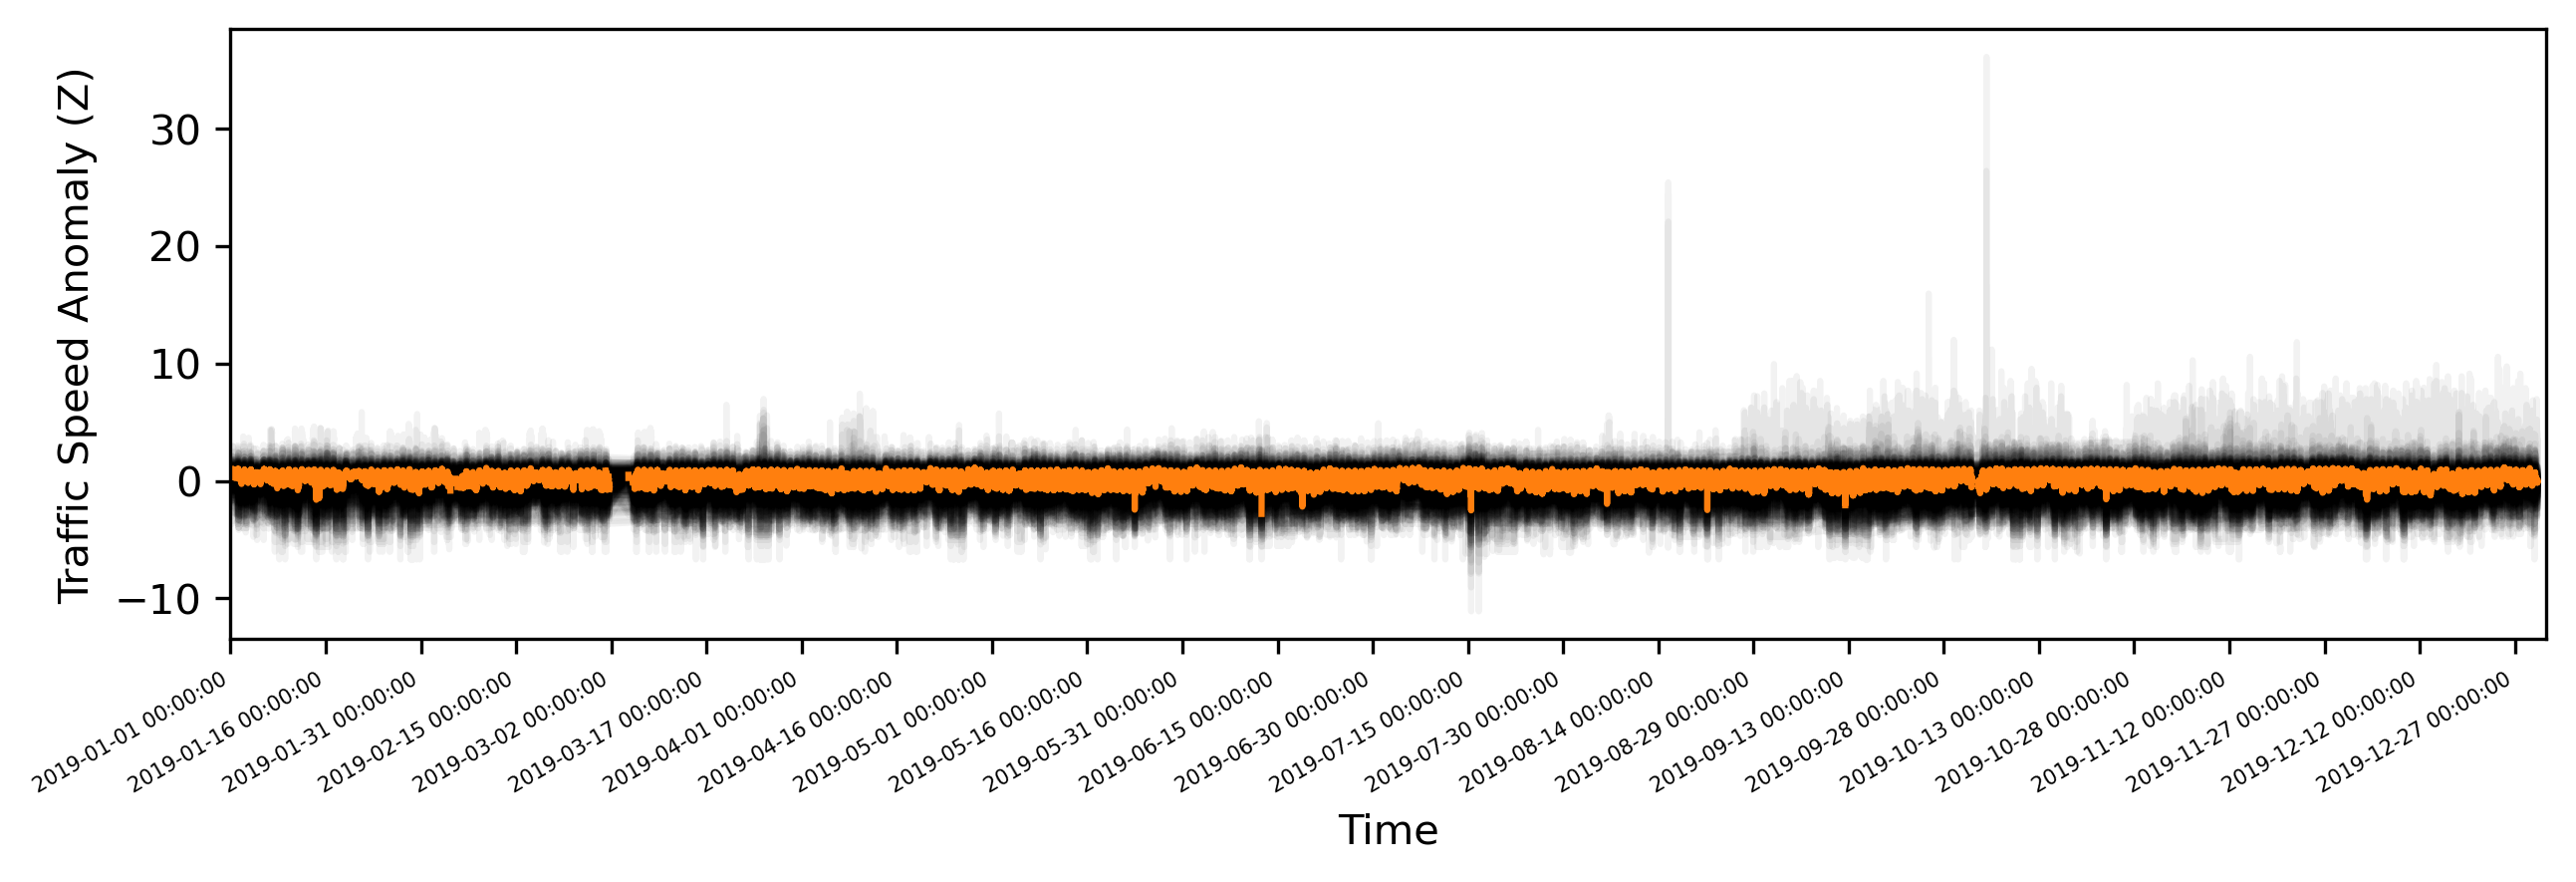

In [7]:
start = f'{year}-01-01'
end = f'{year+1}-01-01'

df_rs = utils.plot_traffic_speed(df,start,end,figsize = (10,3),ticks='15D')

### Remove days where we have less than 80% of sensors working 
If too many sensors are down, the median response won't represent the whole city

In [8]:
sensor_outage = df_rs.isna().sum(axis=1)
tol = len(df_rs.columns)-(len(df_rs.columns)*0.80)

cond_keep = sensor_outage<tol
cond_toss = sensor_outage>tol

speed_ts = df_rs.median(axis=1)

speed_ts[cond_toss] = np.nan

In [9]:
cond_toss.sum()/len(cond_toss)

0.04646231146178609

### Visualize removal of days with 20% of sensors malfunctioning

In [10]:
# plt.figure(figsize = (400,3))
# df_rs.isna().sum(axis=1).plot(xlim=('2019-01-01','2019-12-31'))
# plt.scatter(df_rs.isna().sum(axis=1)[cond_toss].index,
#             df_rs.isna().sum(axis=1)[cond_toss],c='r',zorder=20)

In [11]:
# plt.figure(figsize = (400,3))
# df_rs.median(axis=1)[cond_keep].plot(xlim=('2019-01-01','2019-12-31'))

# plt.scatter(df_rs.median(axis=1)[cond_toss].index,
#             df_rs.median(axis=1)[cond_toss],c='r')

### A normal day

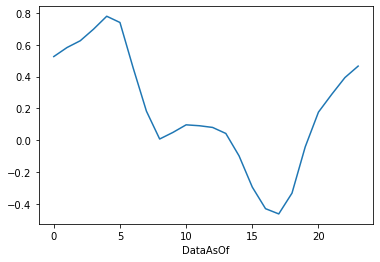

In [12]:
speed_ts.groupby(df_rs.index.hour).mean().plot()

# Clean Weather Data

download weather data via api request

In [13]:
ds = xr.open_dataset('../adaptor.mars.internal-1601005797.0208275-32086-5-a7827603-f995-4e23-b098-fb295de634b1.nc')

In [14]:
ds = ds.mean(dim=['latitude','longitude'])

In [15]:
df_weather = ds.to_dataframe()[['sf','tp']]

In [16]:
df_weather = df_weather[df_weather.index.isin(pd.date_range(f'{year}-01-01',f'{year+1}-01-01',freq='1H'))]
# df_weather.index = df_weather.index.tz_localize(tz = 'UTC')
# df_weather.index  = df_weather.index.tz_convert('US/Eastern')

In [17]:
df_weather['tp_acc'] = df_weather['tp'].rolling(3).sum()
df_weather['sf_acc'] = df_weather['sf'].rolling(3).sum()
df_weather = df_weather.resample('5min').pad()

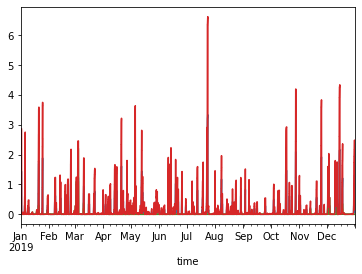

In [18]:
(df_weather['tp']*60).plot()
(df_weather['sf']*60).plot()
(df_weather['sf_acc']*40).plot()
(df_weather['tp_acc']*40).plot()

In [19]:
df_weather.head()

,sf,tp,tp_acc,sf_acc
time,,,,
2019-01-01 00:00:00,9.313226e-10,0.005121,NaN,NaN
2019-01-01 00:05:00,9.313226e-10,0.005121,NaN,NaN
2019-01-01 00:10:00,9.313226e-10,0.005121,NaN,NaN
2019-01-01 00:15:00,9.313226e-10,0.005121,NaN,NaN
2019-01-01 00:20:00,9.313226e-10,0.005121,NaN,NaN


# Merge Weather and Traffic Data

In [20]:
is_edt = pd.date_range(f'{year}-03-11',f'{year}-11-03',freq='5min')
if year == 2019:
    is_edt = is_edt-pd.Timedelta('1D')

In [21]:
speed_ts.index.to_series()

DataAsOf
2019-01-01 02:00:00   2019-01-01 02:00:00
2019-01-01 02:05:00   2019-01-01 02:05:00
2019-01-01 02:10:00   2019-01-01 02:10:00
2019-01-01 02:15:00   2019-01-01 02:15:00
2019-01-01 02:20:00   2019-01-01 02:20:00
                              ...        
2019-12-30 13:30:00   2019-12-30 13:30:00
2019-12-30 13:35:00   2019-12-30 13:35:00
2019-12-30 13:40:00   2019-12-30 13:40:00
2019-12-30 13:45:00   2019-12-30 13:45:00
2019-12-30 13:50:00   2019-12-30 13:50:00
Freq: 5T, Name: DataAsOf, Length: 104687, dtype: datetime64[ns]

In [22]:
df_new = pd.DataFrame()
df_new['speed_ts'] = speed_ts
df_new['time'] = speed_ts.index.to_series()
df_new

,speed_ts,time
DataAsOf,,
2019-01-01 02:00:00,0.319319,2019-01-01 02:00:00
2019-01-01 02:05:00,0.310966,2019-01-01 02:05:00
2019-01-01 02:10:00,0.328083,2019-01-01 02:10:00
2019-01-01 02:15:00,0.345164,2019-01-01 02:15:00
2019-01-01 02:20:00,0.328083,2019-01-01 02:20:00
...,...,...
2019-12-30 13:30:00,-0.095564,2019-12-30 13:30:00
2019-12-30 13:35:00,-0.102386,2019-12-30 13:35:00
2019-12-30 13:40:00,-0.131715,2019-12-30 13:40:00


In [23]:
df_new['time'][df_new['time'].isin(is_edt)] = df_new['time'][df_new['time'].isin(is_edt)]+pd.Timedelta('4H')
df_new['time'][~df_new['time'].isin(is_edt)] = df_new['time'][~df_new['time'].isin(is_edt)]+pd.Timedelta('5H')

<ipython-input-23-2fa3f1874f9d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['time'][df_new['time'].isin(is_edt)] = df_new['time'][df_new['time'].isin(is_edt)]+pd.Timedelta('4H')
<ipython-input-23-2fa3f1874f9d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['time'][~df_new['time'].isin(is_edt)] = df_new['time'][~df_new['time'].isin(is_edt)]+pd.Timedelta('5H')


In [24]:
speed_ts_utc = df_new.set_index('time')['speed_ts']
speed_ts_utc = speed_ts_utc.groupby(speed_ts_utc.index).first()

In [25]:
df_norm = df_weather
df_norm['speed'] = speed_ts_utc.resample('5min').mean()
df_norm = df_norm[df_norm.index.isin(speed_ts_utc.index)]

<ipython-input-26-44badb9e6e52>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_norm['speed'][cond]=df_norm['speed'][cond]*noise


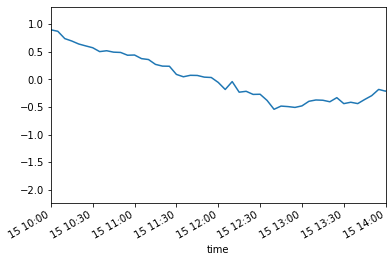

In [26]:
cond = df_norm['speed'].isna()
df_norm = df_norm.interpolate(method='linear',limit=12)
noise = np.random.normal(1,0.08,cond.sum())

df_norm['speed'][cond]=df_norm['speed'][cond]*noise
df_norm['speed'].plot(xlim=('2019-07-15 10:00','2019-07-15 14:00'))
df_norm.index = df_norm.index.tz_localize('UTC')
df_norm.index = df_norm.index.tz_convert('US/Eastern')

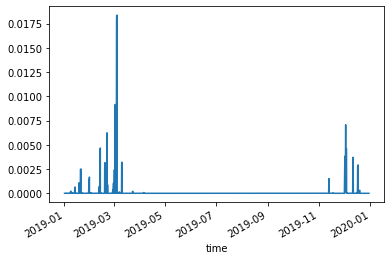

In [27]:
df_norm['sf'].plot()

In [28]:
# means = df_norm.mean()
# stds = df_norm.std()


df_norm['speed'] = (df_norm['speed'] - 0.181692)/0.461967

dhour = (df_norm.index.hour.values+df_norm.index.minute.values/60)

# normalize using sin
# df_norm['month'] = np.sin((df_norm.index.month/df_norm.index.month.max())*2*np.pi)
df_norm['weekday'] = (df_norm.index.dayofweek < 5).astype(int)
df_norm['hour'] = np.sin((dhour/24)*2*np.pi)

df_norm['tp'] = df_norm['tp']*60 # cubic normalization for these data
df_norm['sf'] = df_norm['sf']*60 # no additional norm for these data
df_norm['tp_acc'] = df_norm['tp_acc']*40
df_norm['sf_acc'] = df_norm['sf_acc']*40

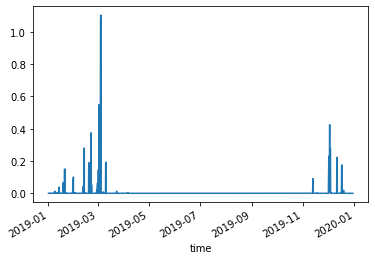

In [29]:
df_norm['sf'].plot()

In [30]:
week_days = df_norm[df_norm.index.dayofweek < 5]
week_ends = df_norm[df_norm.index.dayofweek > 4]

In [31]:
normal_wd = week_days.groupby(week_days.index.hour).mean()
normal_we = week_ends.groupby(week_ends.index.hour).mean()
normal_wd['tp'] = 0
normal_wd['sf'] = 0
normal_wd['tp_acc'] = 0
normal_wd['sf_acc'] = 0
normal_we['tp'] = 0
normal_we['sf'] = 0
normal_we['tp_acc'] = 0
normal_we['sf_acc'] = 0

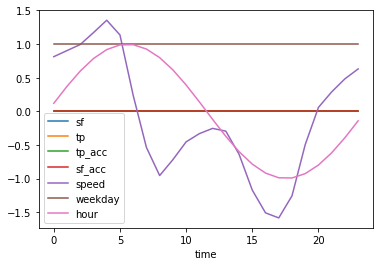

In [32]:
normal_wd.plot()

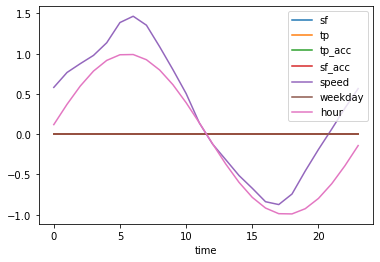

In [33]:
normal_we.plot()

In [34]:
df_copy = df_norm
count = 0

for group in df_copy.groupby(df_copy.index.dayofyear):
    
    n_na = group[1]['speed'].isna().sum().max()
    
    if n_na > 1:
        
        if group[1].index.dayofweek[1] > 4:
        
            copy = group[1].resample('1H').mean()
            copy = normal_we.set_index(copy.index)
            copy = copy.resample('5min').interpolate('cubic')

            noise = np.random.normal(1,0.08,len(copy['speed']))
            copy['speed'] = copy['speed']*noise
            
        if group[1].index.dayofweek[1] < 5:
            
            start = group[1].resample('1H').mean().index[0]
            copy = normal_wd.set_index(pd.date_range(start=start,freq='1H',periods=24))
            copy = copy.resample('5min').interpolate('cubic')

            noise = np.random.normal(1,0.08,len(copy['speed']))
            copy['speed'] = copy['speed']*noise
            
        df_norm[df_norm.index.isin(copy.index)] = copy
        
        count += 1

In [35]:
print(count)

34


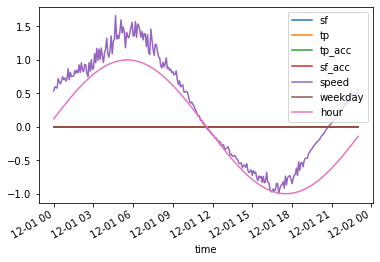

In [36]:
copy.plot()

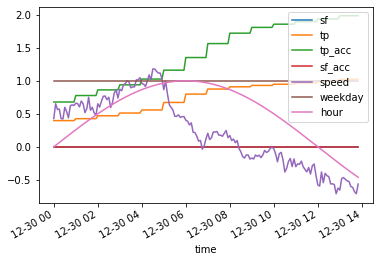

In [37]:
group[1].plot()

In [38]:
df_norm = df_norm.interpolate('linear')
df_norm = df_norm[~df_norm.index.isin([year+1])]

In [39]:
df_norm.index = df_norm.index.tz_convert(None)
df_norm.to_csv(f'df_norm_{year}.csv')

In [40]:
df_norm.tail()

,sf,tp,tp_acc,sf_acc,speed,weekday,hour
time,,,,,,,
2019-12-30 18:30:00,5.587935e-08,1.022497,1.985636,1.117587e-07,-0.600163,1.0,-0.382683
2019-12-30 18:35:00,5.587935e-08,1.022497,1.985636,1.117587e-07,-0.614931,1.0,-0.402747
2019-12-30 18:40:00,5.587935e-08,1.022497,1.985636,1.117587e-07,-0.678418,1.0,-0.422618
2019-12-30 18:45:00,5.587935e-08,1.022497,1.985636,1.117587e-07,-0.710398,1.0,-0.442289
2019-12-30 18:50:00,5.587935e-08,1.022497,1.985636,1.117587e-07,-0.563854,1.0,-0.461749


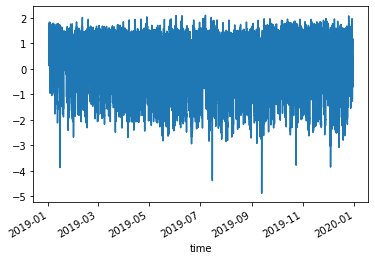

In [41]:
df_norm.speed.plot()

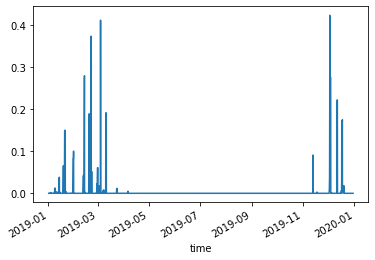

In [42]:
df_norm.sf.plot()